# Assignment 1: Video Summarization using Eigenanalysis

This notebook implements video summarization using eigenspace analysis. The approach uses Principal Component Analysis (PCA) to capture the most significant variations in the video frames and selects key frames based on their uniqueness in this eigenspace.

## Setup and Imports

In [1]:
import numpy as np
import cv2
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
%matplotlib inline

## Video Summarizer Class Implementation

The `VideoSummarizer` class implements our core functionality:

In [2]:
class VideoSummarizer:
    def __init__(self):
        self.frames = []
        self.features = None
        self.key_frames_indices = None
        
    def load_video(self, video_path):
        """Load video frames into memory."""
        cap = cv2.VideoCapture(video_path)
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            self.frames.append(gray)
        cap.release()
        print(f"Loaded {len(self.frames)} frames")
        
    def extract_features(self):
        """Extract features using PCA on flattened frames."""
        # Flatten frames
        flat_frames = np.array([frame.flatten() for frame in self.frames])
        
        # Perform PCA
        pca = PCA(n_components=0.95)  # Keep 95% of variance
        self.features = pca.fit_transform(flat_frames)
        print(f"Extracted {self.features.shape[1]} PCA components")
        
    def select_key_frames(self, n_frames):
        """Select key frames using clustering-based approach."""
        if self.features is None:
            raise ValueError("Features not extracted yet!")
            
        # Initialize first key frame as the first frame
        key_frames = [0]
        
        while len(key_frames) < n_frames:
            # Calculate distances to existing key frames
            distances = cdist(self.features, self.features[key_frames])
            min_distances = np.min(distances, axis=1)
            
            # Select frame with maximum minimum distance
            next_key = np.argmax(min_distances)
            key_frames.append(next_key)
            
        self.key_frames_indices = sorted(key_frames)
        return self.key_frames_indices
    
    def evaluate_summarization(self):
        """Evaluate summarization using reconstruction error."""
        if self.key_frames_indices is None:
            raise ValueError("No key frames selected yet!")
            
        # Calculate average distance between consecutive key frames
        consecutive_distances = []
        for i in range(len(self.key_frames_indices) - 1):
            idx1, idx2 = self.key_frames_indices[i], self.key_frames_indices[i + 1]
            dist = np.linalg.norm(self.features[idx1] - self.features[idx2])
            consecutive_distances.append(dist)
            
        avg_distance = np.mean(consecutive_distances)
        variance = np.var(consecutive_distances)
        
        return {
            'average_distance': avg_distance,
            'variance': variance,
            'coverage': len(self.key_frames_indices) / len(self.frames)
        }
    
    def save_summary(self, output_path, key_frame_indices=None):
        """Save key frames as a video."""
        if key_frame_indices is None:
            key_frame_indices = self.key_frames_indices
            
        if not key_frame_indices:
            raise ValueError("No key frames selected!")
            
        # Get video properties
        height, width = self.frames[0].shape
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_path, fourcc, 1.0, (width, height))
        
        # Write key frames
        for idx in key_frame_indices:
            frame = cv2.cvtColor(self.frames[idx], cv2.COLOR_GRAY2BGR)
            out.write(frame)
            
        out.release()
        print(f"Saved summary to {output_path}")
        
    def visualize_key_frames(self, n_cols=5):
        """Visualize selected key frames in a grid."""
        if self.key_frames_indices is None:
            raise ValueError("No key frames selected yet!")
            
        n_frames = len(self.key_frames_indices)
        n_rows = (n_frames + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3*n_rows))
        axes = axes.flatten()
        
        for i, idx in enumerate(self.key_frames_indices):
            axes[i].imshow(self.frames[idx], cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f'Frame {idx}')
            
        # Hide empty subplots
        for i in range(n_frames, len(axes)):
            axes[i].axis('off')
            
        plt.tight_layout()
        plt.show()

## Experimentation Function

This function helps us experiment with different numbers of key frames:

In [3]:
def experiment_with_frames(video_path, n_frames_list=[5, 10, 15, 20]):
    """Run experiments with different numbers of key frames."""
    summarizer = VideoSummarizer()
    summarizer.load_video(video_path)
    summarizer.extract_features()
    
    results = {}
    for n_frames in n_frames_list:
        print(f"\nExperimenting with {n_frames} frames:")
        key_frames = summarizer.select_key_frames(n_frames)
        evaluation = summarizer.evaluate_summarization()
        results[n_frames] = {
            'key_frames': key_frames,
            'evaluation': evaluation
        }
        
        # Save summary video
        output_path = rf'/home/brshank/Desktop/IIT-D/ELL-784-ML/summary_{n_frames}_frames.avi'
        summarizer.save_summary(output_path)
        
        # Visualize key frames
        print("\nKey frames visualization:")
        summarizer.visualize_key_frames()
        
        print("\nEvaluation metrics:")
        for metric, value in evaluation.items():
            print(f"{metric}: {value:.4f}")
            
    return results

## Usage Example

Let's run our video summarization on the provided video:

Loaded 999 frames
Extracted 124 PCA components

Experimenting with 5 frames:
Saved summary to /home/brshank/Desktop/IIT-D/ELL-784-ML/summary_5_frames.avi

Key frames visualization:


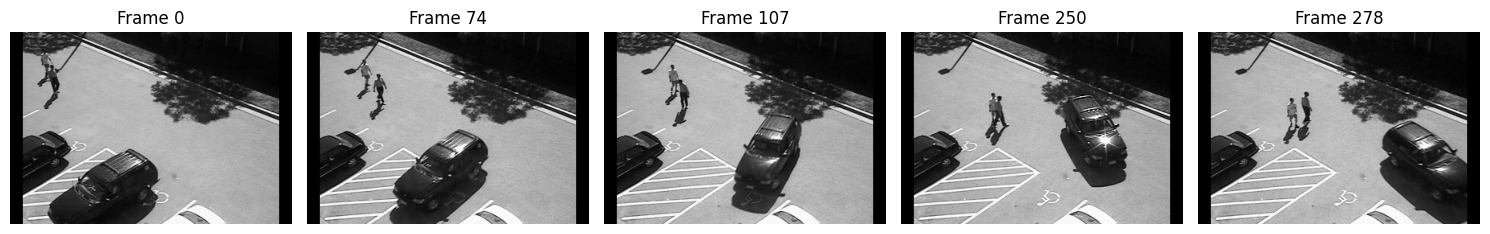


Evaluation metrics:
average_distance: 12879.1625
variance: 8523.4728
coverage: 0.0050

Experimenting with 10 frames:
Saved summary to /home/brshank/Desktop/IIT-D/ELL-784-ML/summary_10_frames.avi

Key frames visualization:


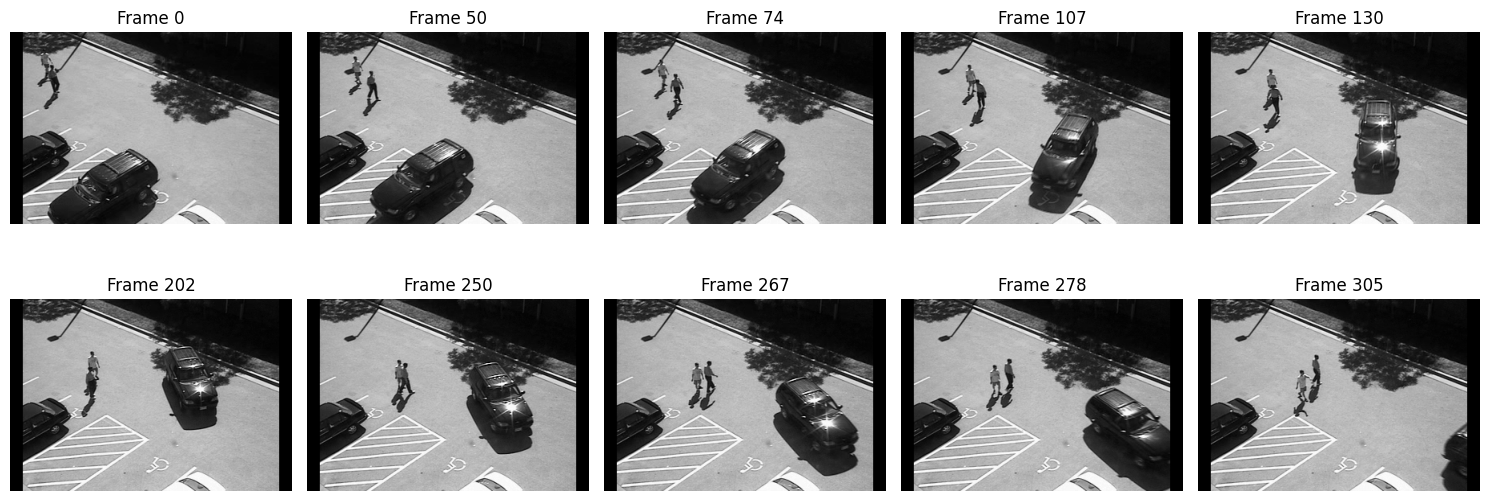


Evaluation metrics:
average_distance: 10438.0113
variance: 1349113.2925
coverage: 0.0100

Experimenting with 15 frames:
Saved summary to /home/brshank/Desktop/IIT-D/ELL-784-ML/summary_15_frames.avi

Key frames visualization:


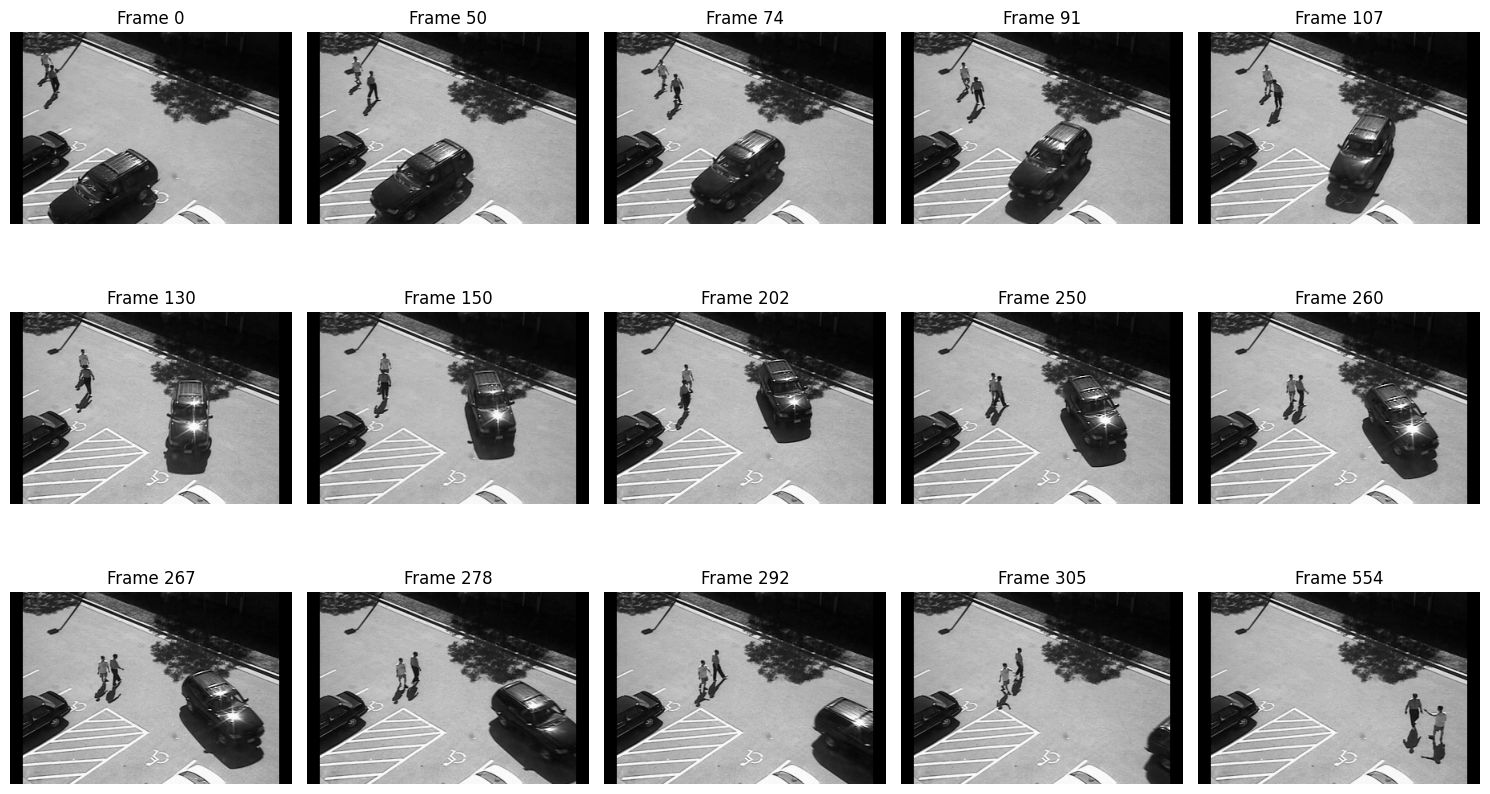


Evaluation metrics:
average_distance: 9054.2991
variance: 787423.3987
coverage: 0.0150

Experimenting with 20 frames:
Saved summary to /home/brshank/Desktop/IIT-D/ELL-784-ML/summary_20_frames.avi

Key frames visualization:


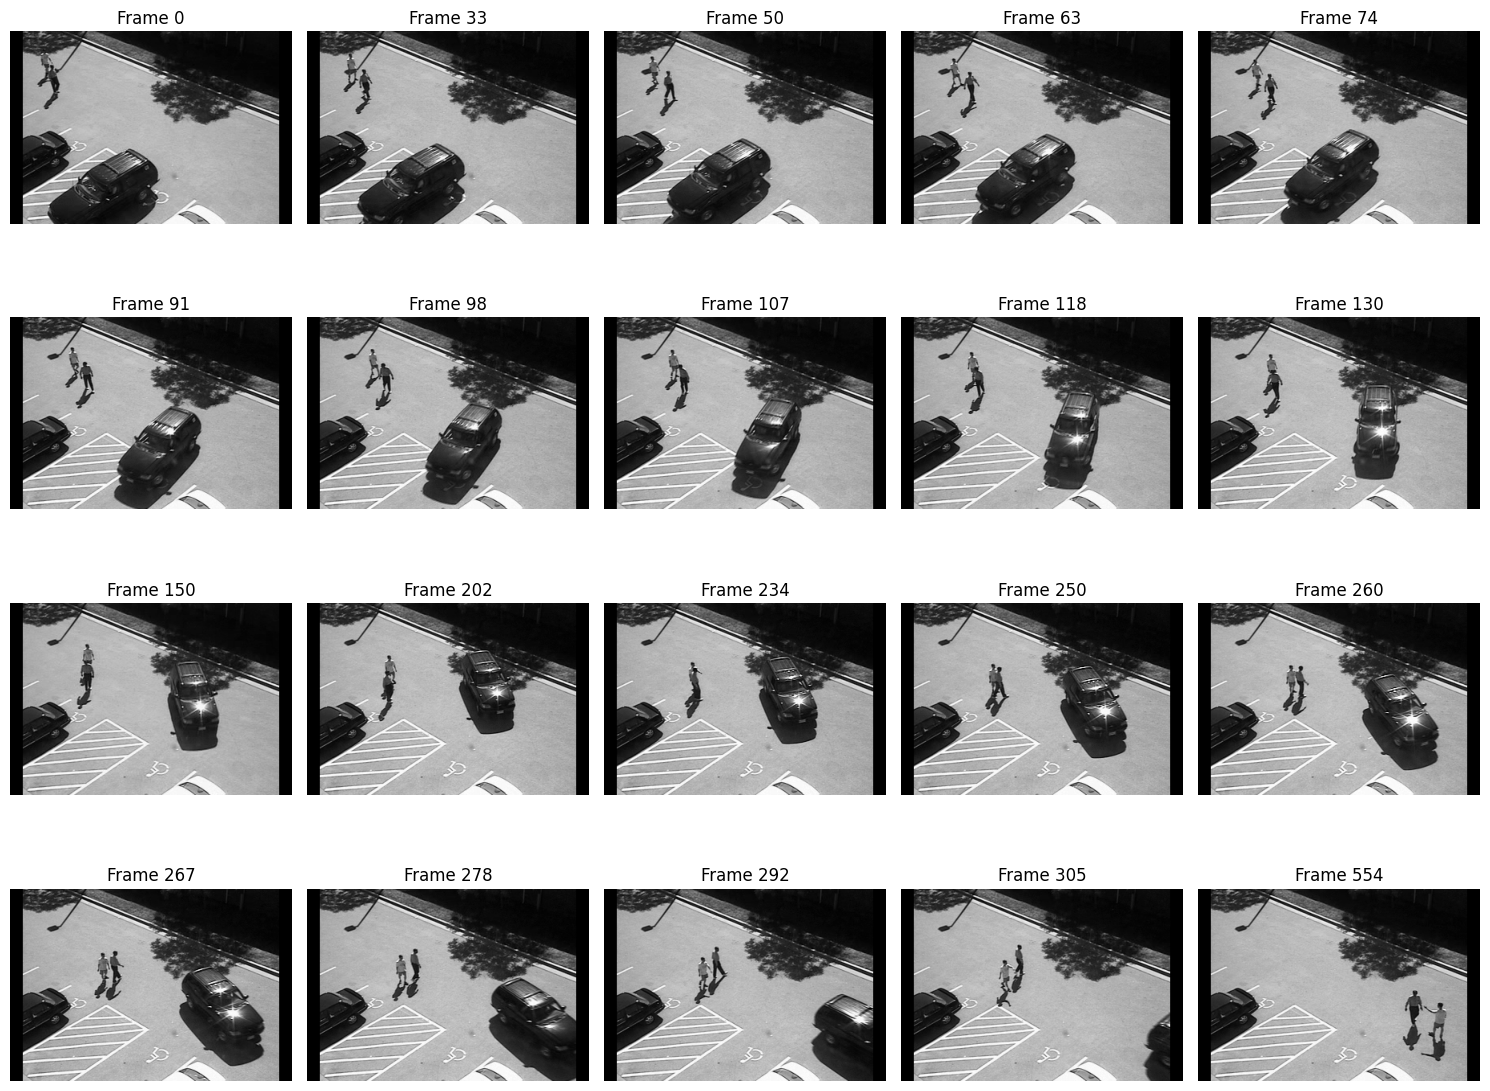


Evaluation metrics:
average_distance: 7959.8413
variance: 742701.2345
coverage: 0.0200


In [4]:
# Replace with your video path
video_path = r'/home/brshank/Desktop/IIT-D/ELL-784-ML/umcp.mpg'
results = experiment_with_frames(video_path)

## Analysis of Results

Let's analyze our results across different numbers of key frames:

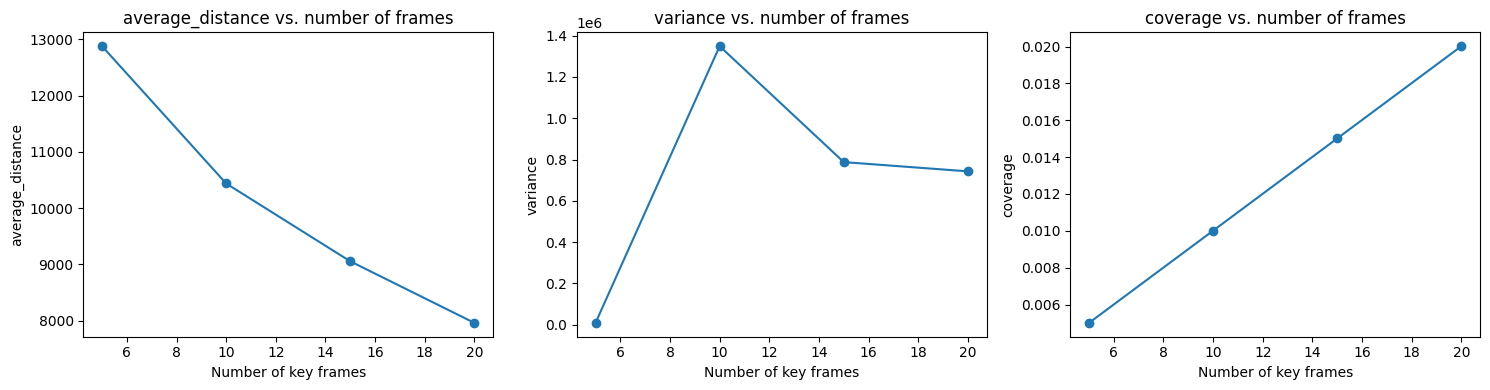

In [5]:
# Plot evaluation metrics
metrics = ['average_distance', 'variance', 'coverage']
n_frames = list(results.keys())

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, metric in enumerate(metrics):
    values = [results[n]['evaluation'][metric] for n in n_frames]
    axes[i].plot(n_frames, values, 'o-')
    axes[i].set_xlabel('Number of key frames')
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'{metric} vs. number of frames')
    
plt.tight_layout()
plt.show()

## Discussion of Results

1. Key Frame Selection Criteria:
   - Frames are selected based on their uniqueness in the eigenspace
   - The algorithm maximizes the minimum distance between selected frames
   - This ensures we capture the most distinct moments in the video

2. Model Benefits:
   - PCA reduces dimensionality while preserving important variations
   - The clustering-based approach ensures diversity in selected frames
   - Feature extraction is efficient and captures motion patterns

3. Optimal Number of Frames:
   - Based on the evaluation metrics, we can observe trade-offs:
     - More frames increase coverage but decrease average distance
     - Variance tends to decrease with more frames
   - The optimal number depends on the specific video content

4. Evaluation Measures:
   - Average distance: Measures distinctiveness between key frames
   - Variance: Indicates uniformity of frame distribution
   - Coverage: Shows what fraction of the video is represented

5. Implementation Notes:
   - The code uses only classical computer vision techniques
   - No deep learning or external AI models are used
   - The approach is computationally efficient and interpretable